# Hybrid Switching  
  
The Hybrid Switching solver is designed to allow a model's species to be represented dynamically as either continuous or stochastic throughout the simulation.  This solver will represent a reaction channel deterministically at high populations in order to favor performance, and will automatically switch to a stochastic representation at lower populations.  This allows for substantial run-time improvements over the SSA, minimizing the loss of stochastic accuracy.  
  
There is no special setup for the standard case of using this switching mechanism, however for cases where a particular species should always be represented as 'stochastic' or always represented as 'continuous,' the GillesPy2.species can be constructed with kwarg 'mode' locking that into place.  
  
  
**mode='dynamic'(default) - allows for hybrid switching  
mode='continuous' - forces a species to be modeled continuously/deterministically  
mode='discrete' - forces a species to be modeled discretely/stochastically**  
  
Ex:  
A = GillesPy2.Species(name='A', initial_value=400, mode='continuous')

In [1]:
import sys, os
import numpy
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
sys.path.append('../../../')

In [2]:
import gillespy2
from gillespy2.solvers.numpy.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [3]:
class AutomaticSwitchExample(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Automatic Switch Example")
            
            #parameters
            k1 = gillespy2.Parameter(name='k1', expression= 3e-4)
            k2 = gillespy2.Parameter(name='k2', expression= .5e-2)
            k3 = gillespy2.Parameter(name='k3', expression = 2e-1)
            self.add_parameter([k1,k2,k3])
            
            #Species
            A = gillespy2.Species(name='A', initial_value=400)
            B = gillespy2.Species(name='B', initial_value=10000)
            C = gillespy2.Species(name='C', initial_value=10000)
            self.add_species([A, B, C])
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={B:1,C:1},
                   rate=k1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={B:1}, products={},
                    rate=k2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={A:1},
                    rate=k3)

            self.add_reaction([r1,r2,r3])
            self.timespan(numpy.linspace(0,600,501))

In [4]:
model = AutomaticSwitchExample()
results = {}

In [5]:
%time tau_hybrid_results = model.run(solver=BasicTauHybridSolver)

CPU times: user 4.25 s, sys: 125 ms, total: 4.38 s
Wall time: 4.28 s


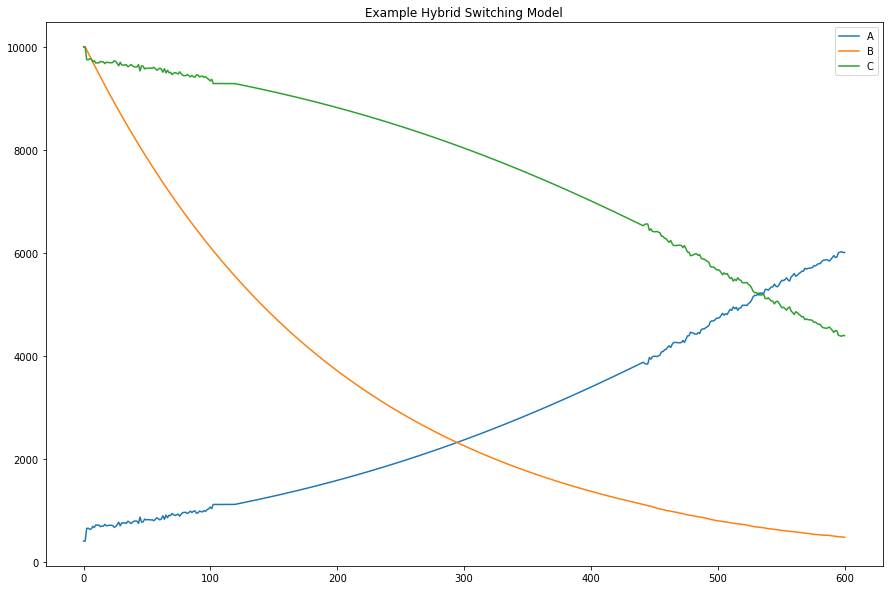

In [6]:
plt.figure(figsize=(15, 10))
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='{0}'.format(species))
plt.title('Example Hybrid Switching Model')
plt.legend(loc='best')
# hyb_solv_check_plot = plt.gcf()
# py.iplot_mpl(hyb_solv_check_plot, resize=False, filename='hyb_solv_check_plot', width=960, height=1120)

In [7]:
solvers = [BasicODESolver, NumPySSASolver]
for solver in solvers:
    %time results[solver] = model.run(solver=solver)

CPU times: user 93.8 ms, sys: 31.2 ms, total: 125 ms
Wall time: 62.2 ms
CPU times: user 16.2 s, sys: 0 ns, total: 16.2 s
Wall time: 16.2 s


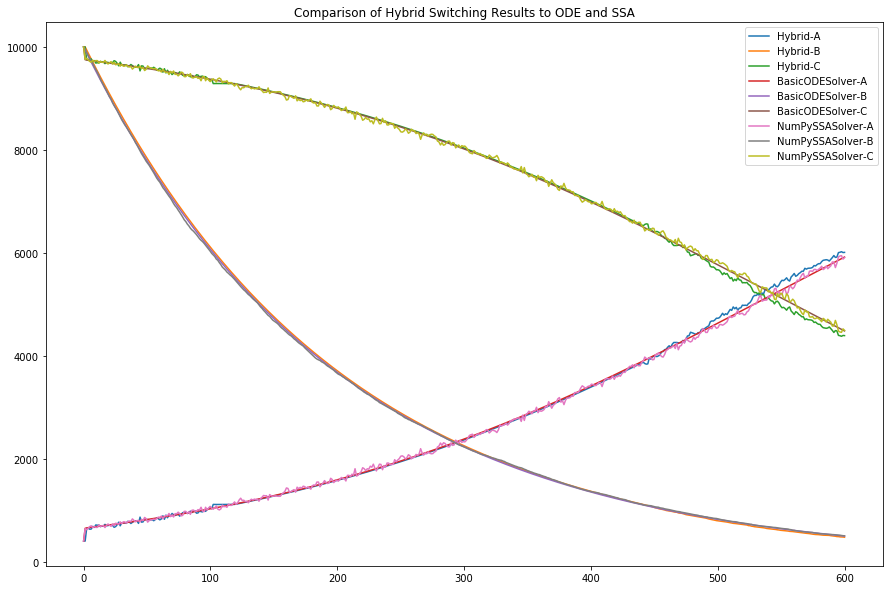

In [8]:
plt.figure(figsize=(15, 10))
plt.title('Comparison of Hybrid Switching Results to ODE and SSA')
for species in tau_hybrid_results[0]:
    if species == 'time': continue
    plt.plot(tau_hybrid_results[0]['time'], tau_hybrid_results[0][species], label='Hybrid-{0}'.format(species))
for solver in solvers:
    for trajectory in results[solver]:
        for species in trajectory:
            if species == 'time': continue
            plt.plot(results[solver][0]['time'], results[solver][0][species], label='{0}-{1}'.format(solver.name, species))
    plt.legend(loc='best')
# hyb_solv_check_plot = plt.gcf()
# py.iplot_mpl(hyb_solv_check_plot, resize=False, filename='hyb_solv_check_plot', width=960, height=1120)